In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import sys

# Import circuits and gates
sys.path.append('../../scripts/')
import behavior_gates as bg
import circuits as circ
input_behaviors = ['col_cmd','sloppy_joy_cmd', 'nav_cmd']

#import map data
sys.path.append('../../maps/')
import yaml
import matplotlib.image as mpimg
with open("../../maps/map.yaml", 'r') as stream:
    map_info = yaml.safe_load(stream)
map_img =mpimg.imread('../../maps/map.png')

# Helper Functions Twist

In [86]:

'''
calculates the difference betweeen two topics even if they are not synchronous.

It always uses the time resolution of the reference_data
'''
def find_nearest_index(data,reference_time):
    smaller_indexes     = np.array((data['time'] <=reference_time).tolist())
    matching_data_index = np.argmin(smaller_indexes)
    return matching_data_index

'''
plot all behaviors (resulting and input) of a given expierment in a given control axis (v, omega)
'''
def plot_behavior(participent_nr,experiment,control_axis,x_range = None ,y_range = None, circuit = None,homing=False):
    plt.figure(figsize = (11.69,8.27))
    topic_names = deepcopy(input_behaviors)
    if circuit  == None:
        topic_names.insert(0,'cmd_vel')
    else:
        twist_df = simulate_circuit(participent_nr,experiment,circ.main_circuit,homing)
        plt.step(twist_df['time']-twist_df['time'][0], twist_df[control_axis], label="cmd_vel")
        
    if homing == True:
        topic_names = ['homing_cmd' if x == 'nav_cmd' else x for x in topic_names]
    for topic_name in topic_names:
        twist_df   = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + topic_name + ".csv")
        
        #normalize to display gate input, compare with circuit.py main_circuit() function
        if topic_name == 'col_cmd': 
            twist_df['v'] = 10 * twist_df['v']
        #account for slower speed linear speed of circuit due to remapping (see fusion.py line 19)
        if topic_name == 'cmd_vel': 
            twist_df['v'] = twist_df['v']/0.8
        plt.step(twist_df['time']-twist_df['time'][0], twist_df[control_axis], label=topic_name)
    
    if x_range != None:
        plt.xlim(x_range)
    if y_range != None:
        plt.ylim(y_range)
    plt.legend(loc="lower left")
    plt.show()


'''
Upsamples a dataframe according to another, repeating the last value until a new one is encountered.
'''
def upsample(data,times):
    new_data = deepcopy(times)
    for index, row in times.iterrows():
        reference_time = row['time']
        corr_index = find_nearest_index(data,reference_time)
        new_data['v'][index]     = data['v'][corr_index]
        new_data['omega'][index] = data['omega'][corr_index]    
    return new_data
    
    
'''
correlates all input behaviors wih the final output.
'''
def plot_correlate(participent_nr,experiment,control_axis,x_range = None ,y_range = None):
    plt.figure(figsize = (11.69,8.27))
    topic_names = deepcopy(input_behaviors)
    output_twist_df = twist_df   = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + "cmd_vel" + ".csv")
    
    output_behavior =  output_twist_df[control_axis].tolist()
    output_behavior_array = np.array(output_behavior)
    for topic_name in topic_names:
        twist_df   = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + topic_name + ".csv")
        upsampled_twist = upsample(twist_df,output_twist_df)
        behavior_array = np.array(upsampled_twist[control_axis].tolist())
        plt.step(output_twist_df['time']-output_twist_df['time'][0], 
                 np.correlate(behavior_array,output_behavior_array, "same"), label=topic_name)
    
    if x_range != None:
        plt.xlim(x_range)
    if y_range != None:
        plt.ylim(y_range)
    plt.legend(loc="lower left")
    plt.step(output_twist_df['time']-output_twist_df['time'][0],
             np.correlate(output_twist_df[control_axis].tolist(),
                          output_twist_df[control_axis].tolist(),"sane"),label="selfcorrelation")
    plt.show()    


    
'''
correlates all input behaviors wih the final output.
'''
def get_correlate(participent_nr,experiment,control_axis,x_range = None ,y_range = None):
    topic_names = deepcopy(input_behaviors)
    output_twist_df = twist_df   = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + "cmd_vel" + ".csv")
    
    output_behavior =  output_twist_df[control_axis].tolist()
    output_behavior_array = np.array(output_behavior)
    correlate = {}
    for topic_name in topic_names:
        twist_df   = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + topic_name + ".csv")
        upsampled_twist = upsample(twist_df,output_twist_df)
        behavior_array = np.array(upsampled_twist[control_axis].tolist())
        correlate[topic_name] = np.correlate(behavior_array,output_behavior_array)
    return correlate

    
    
    
'''
simulates the usage of a differenc circuit for the inputs of a given experiment
'''
def simulate_circuit(participent_nr,experiment,circuit,homing=False):
    behaviors = np.zeros((4,2))
    original_result = pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_cmd_vel.csv")
    
    org_frames = [pd.read_csv("../experimental_data/participent_" 
                                 + str(participent_nr) + "/" + experiment + "/twist_" + topic_name + ".csv") 
                   for topic_name in input_behaviors]
    
    data_frames = [upsample(frame,original_result) for frame in org_frames]
    

    for index, row in original_result.iterrows():
        reference_time = row['time']
        
        if homing == True:
            homing_frame = pd.read_csv("../experimental_data/participent_" 
                                     + str(participent_nr) + "/" + experiment + "/twist_" + "homing_cmd" + ".csv") 
            corr_index = find_nearest_index(homing_frame,reference_time)
            behaviors[0][0] = homing_frame['v'][corr_index]
            behaviors[0][1] = homing_frame['omega'][corr_index]
        for i in range(len(input_behaviors)):
            corr_index = find_nearest_index(data_frames[i],reference_time)
            behaviors[i+1][0] = data_frames[i]['v'][corr_index]
            behaviors[i+1][1] = data_frames[i]['omega'][corr_index]
            
        circuit_output = circuit(behaviors)
        
        #set rescaled circuit output
        original_result['v'][index]      = 0.8 * circuit_output.linear.x 
        original_result['omega'][index]  =       circuit_output.angular.z   
    return original_result

'''
locate the position of the robot at a given time and returns the circuit input and outputs ad that time.
'''
def locate_position(participent_nr,experiment,time):
    orig_odom_df = pd.read_csv("../experimental_data/participent_" 
                                + str(participent_nr) + "/" + experiment + "/odom.csv")
    #rotate dataframe to account for initial yaw orientation in odometry:
    odom_df = rotate_odom(orig_odom_df)
    
    #get closest index to time 
    closest_sample = odom_df.iloc[(odom_df['time']-odom_df['time'][0]-time).abs().argsort()[:1]]
    return np.array([closest_sample['x'].values[0],
                     closest_sample['y'].values[0]]),closest_sample['yaw'].values[0], closest_sample['time'].values[0]


def visualize_position(participent_nr,experiment,time,x_range = None ,y_range = None):
    plt.figure(figsize=(11.69,8.27))
    pos, ori, time = locate_position(participent_nr,experiment,time)
    
    fig, ax = plt.subplots()
    '''
    map_pos = np.array(map_info['origin'])#*map_info['resolution']
    newax = fig.add_axes([map_pos[0],map_pos[1],
                          map_img.shape[0]*map_info['resolution'], 
                          map_img.shape[1]*map_info['resolution']],zorder=-1)  # Change the numbers in this array to position your image [left, bottom, width, height])
    newax.imshow(map_img)
    newax.axis('off')  # get rid of the ticks and ticklabels
    '''
  
    length = 0.1
    plt.arrow(pos[0], pos[1], length*np.cos(ori), length*np.sin(ori))
    plt.plot([pos[0], pos[0] + length*np.cos(ori) + 0.1], 
             [pos[1], pos[1] + length*np.sin(ori) + 0.1], alpha=0) #needed since plot does not autoscale
    if x_range != None:
        plt.xlim(x_range)
    if y_range != None:
        plt.ylim(y_range)
    plt.show()

    
#for i in range(2,7):
#    print(get_correlate(i,"main_circuit",'omega'))
#plot_correlate(6,"main_circuit",'v')

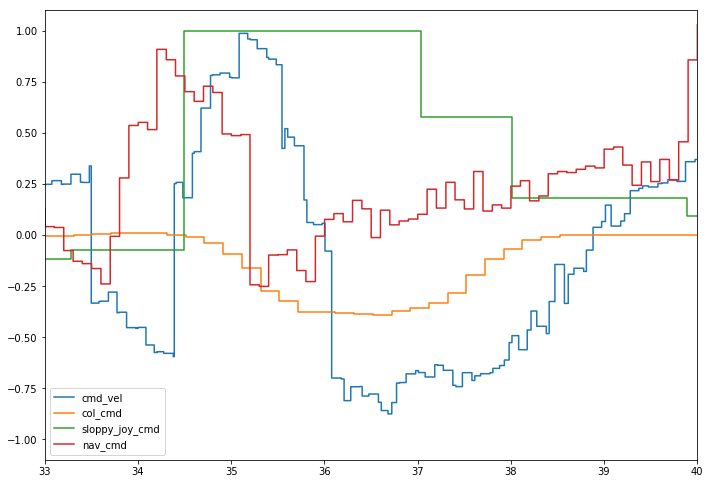

In [25]:
#collision avoidance prevails other behaviors
plot_behavior(2,"main_circuit",'omega',(33,40),(-1.1,1.1))  

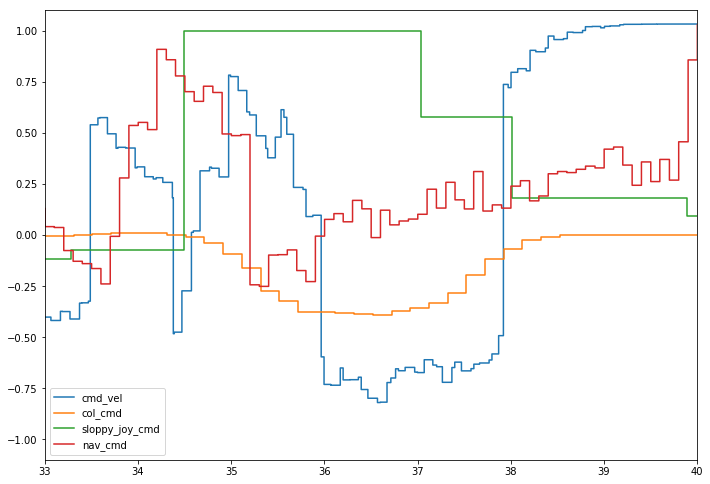

In [62]:
#collision avoidance prevails other behaviors
plot_behavior(2,"main_circuit",'omega',(33,40),(-1.1,1.1),circ.main_circuit)  

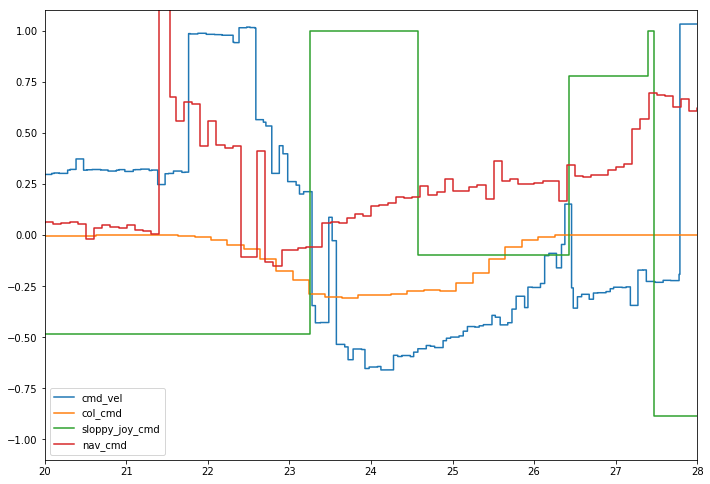

In [44]:
plot_behavior(6,"main_circuit",'omega',(20,28),(-1.1,1.1))

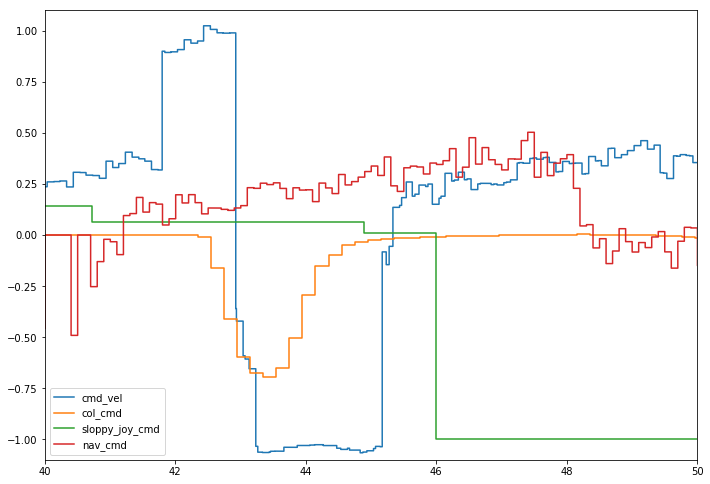

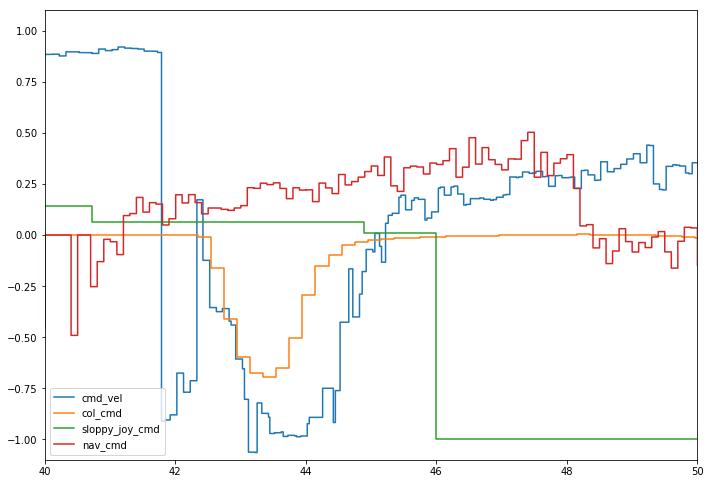

In [61]:
plot_behavior(4,"main_circuit_second_target",'omega',(40,50),(-1.1,1.1))#,circ.main_circuit) 
plot_behavior(4,"main_circuit_second_target",'omega',(40,50),(-1.1,1.1),circ.main_circuit) 

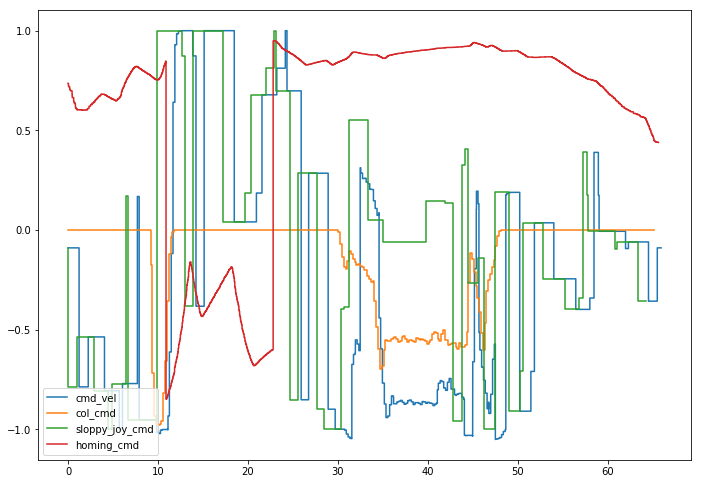

In [87]:
plot_behavior(5,"main_circuit_homing",'omega',circuit=circ.main_circuit_homing,homing=True)

2


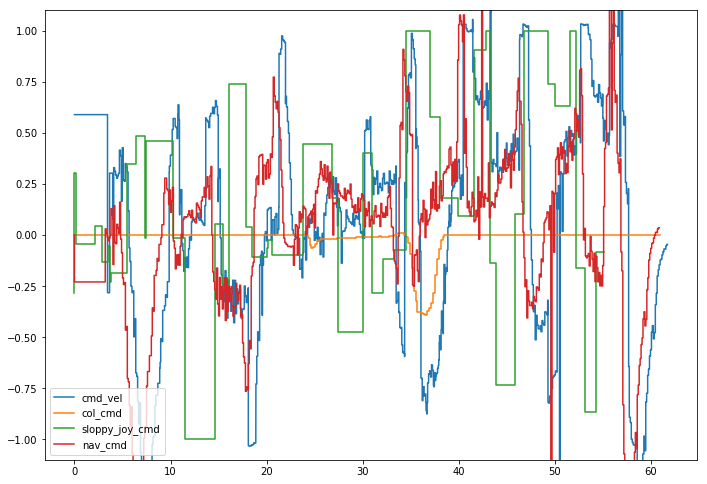

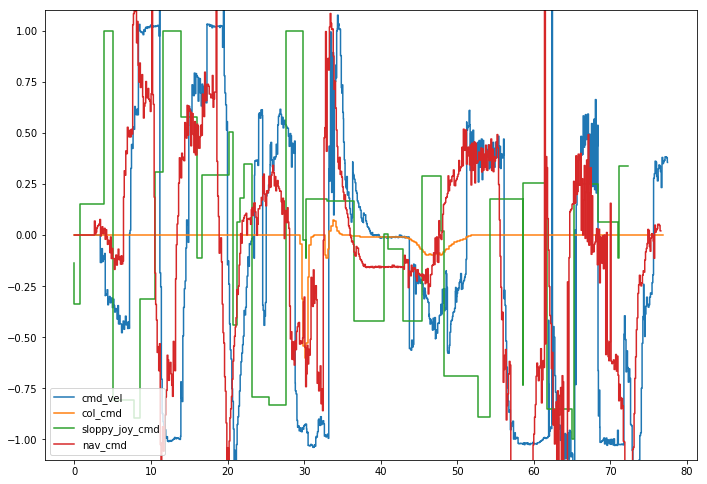

3


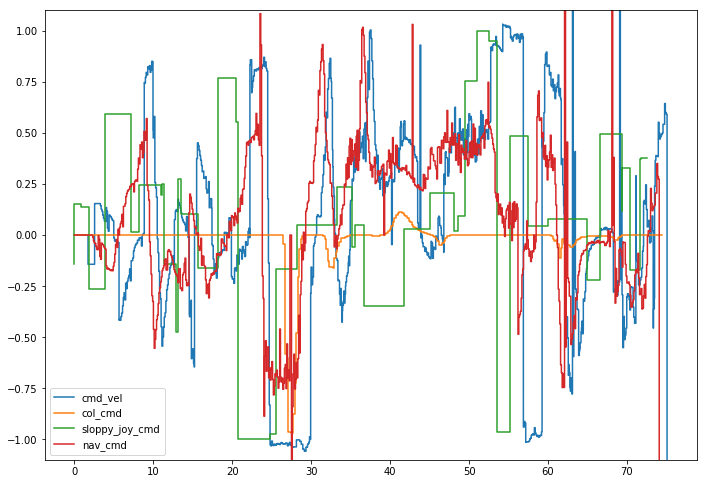

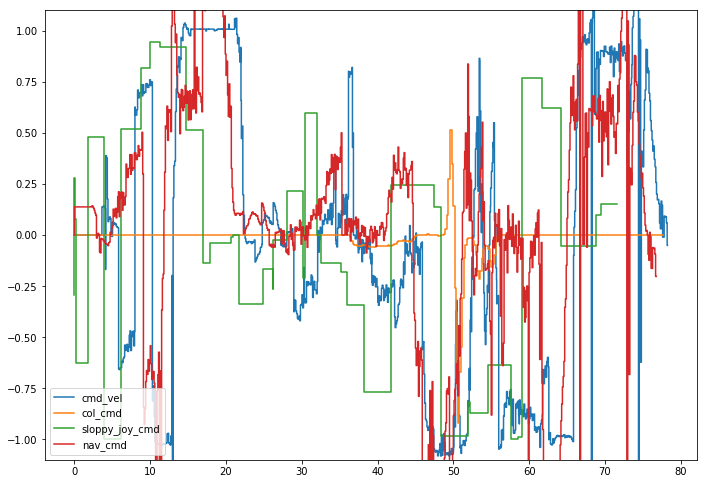

4


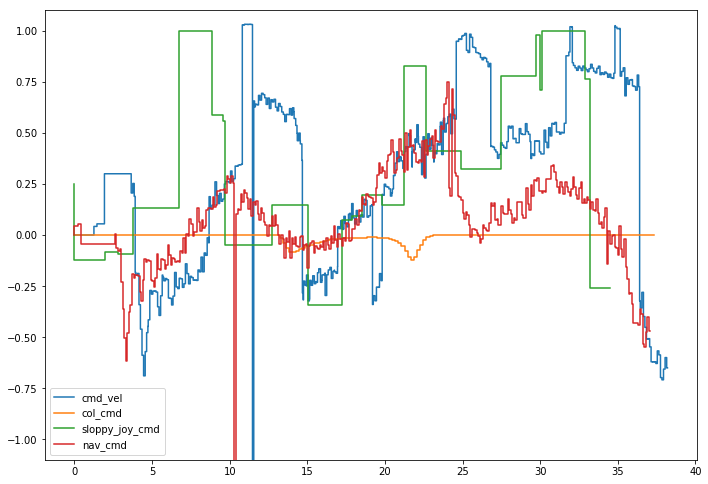

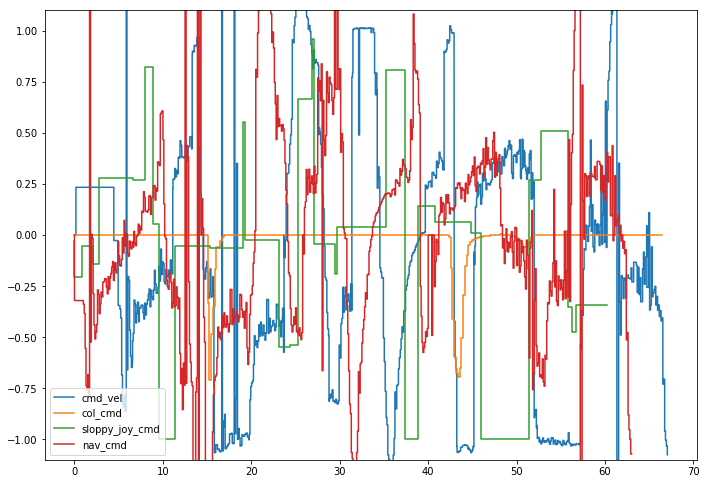

5


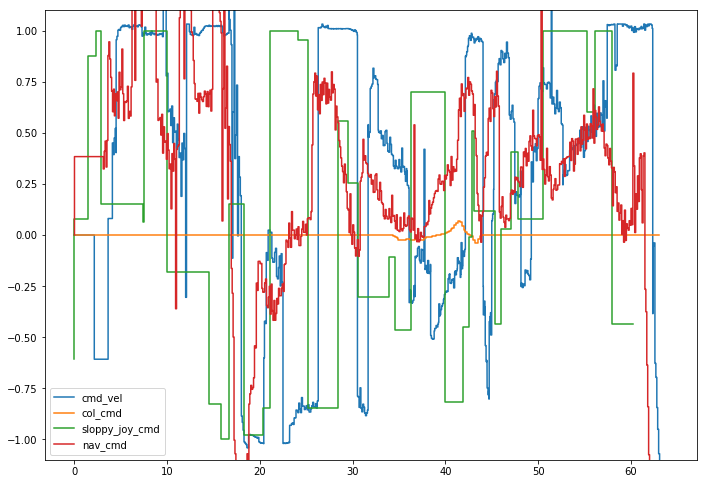

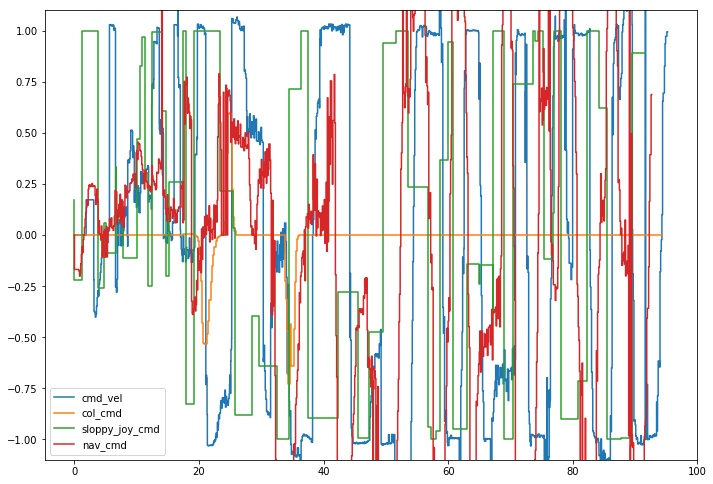

6


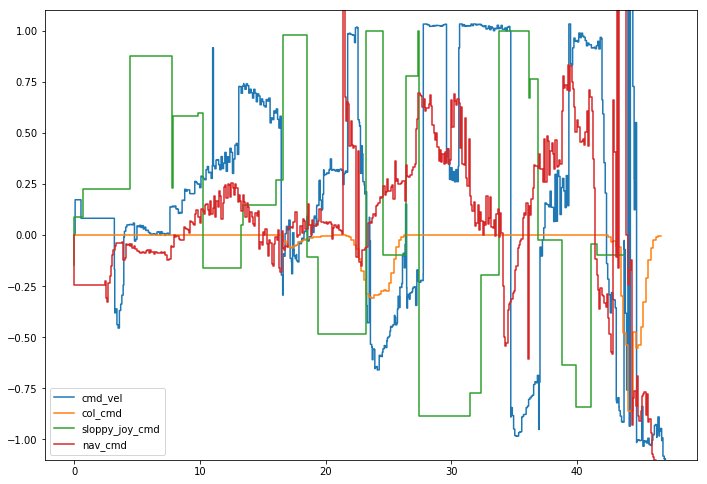

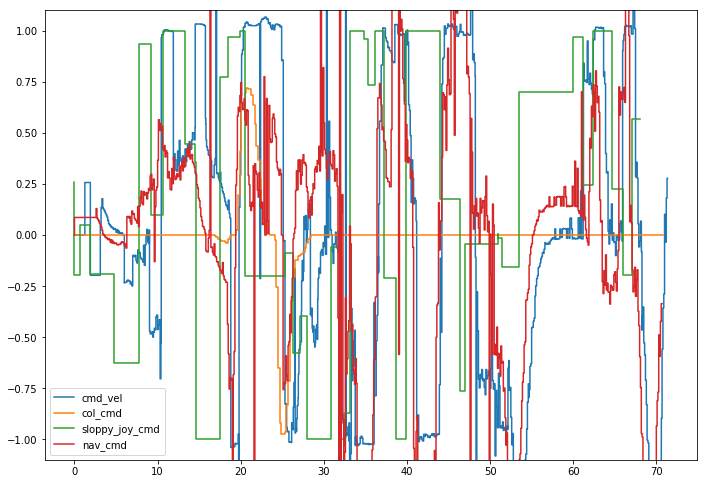

In [37]:
for i in range(2,7):
    print(i)
    plot_behavior(i,"main_circuit",'omega',y_range=(-1.1,1.1)) 
    plot_behavior(i,"main_circuit_second_target",'omega',y_range=(-1.1,1.1)) 

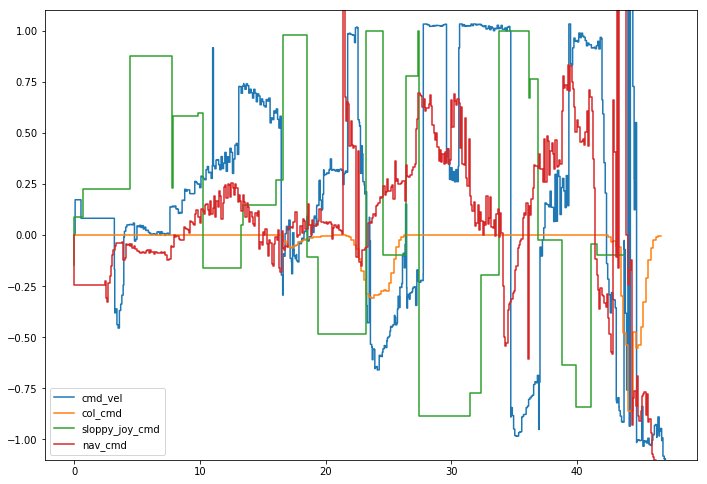

In [35]:
plot_behavior(6,"main_circuit_scond_target",'omega',y_range=(-1.1,1.1))

# plot odom

In [6]:
def angdiff(x,y):
    return min((2 * np.pi) - abs(x - y), abs(x - y))

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]


def determine_smoothness(odom,stepsize = 1,start=1): 
    tau = 1
    angle_diff = []
    for x in np.arange(start, odom['yaw'].count(),stepsize):
        distance = np.sqrt((odom.iloc[(x), 1] - odom.iloc[(x-1), 1])**2 + (odom.iloc[(x), 2] - odom.iloc[(x-1), 2])**2)
        angle_diff.append(angdiff(odom.iloc[(x), 3],odom.iloc[(x-1), 3]))#/max(distance,0.01)*stepsize)
    return np.exp(-tau*sum(autocorr(angle_diff))/odom['yaw'].count())
 
def determine_fluency(odom,stepsize = 1,start=1): 
    tau = 1000
    distance_diff = []
    for x in np.arange(start, odom['yaw'].count()-1,stepsize):
        distance_1 = np.sqrt((odom.iloc[(x), 1] - odom.iloc[(x-1), 1])**2 + (odom.iloc[(x), 2] - odom.iloc[(x-1), 2])**2)
        distance_2 = np.sqrt((odom.iloc[(x+1), 1] - odom.iloc[(x), 1])**2 + (odom.iloc[(x+1), 2] - odom.iloc[(x), 2])**2)
        distance_diff.append(abs(distance_2-distance_1))
    return np.exp(-tau*sum(autocorr(distance_diff))/odom['yaw'].count()*stepsize)


'''
rotate a odometry dataframe so that its initial orientation is yaw= 0
'''
def rotate_odom(odom_df):
    new_df = deepcopy(odom_df)
    initial_yaw = odom_df['yaw'][0]
    rot = np.array([[np.cos(-initial_yaw), -np.sin(-initial_yaw)], [np.sin(-initial_yaw), np.cos(-initial_yaw)]])
    for index, row in new_df.iterrows():
        pos         = np.array([row['x'],row['y']])
        rotated_pos = np.dot(rot,pos)
        
        new_df['x'][index]  = rotated_pos[0]
        new_df['y'][index]  = rotated_pos[1]
        new_df['yaw'][index]= new_df['yaw'][index]-initial_yaw
    return new_df

'''
plots the trajectories of all participents for a given experiment
'''
def plot_odom(experiment,participents):
    plt.figure(figsize=(11.69,8.27))
    for participent_nr in participents:
        orig_odom_df = pd.read_csv("../experimental_data/participent_" 
                                   + str(participent_nr) + "/" + experiment + "/odom.csv")
        #rotate dataframe to account for initial yaw orientation in odometry:
        odom_df = rotate_odom(orig_odom_df)
        plt.plot(odom_df['x'], odom_df['y'], label="participent "+str(participent_nr),zorder=2)
    plt.legend(loc="lower left")
    plt.title(experiment+" Path")
    plt.axis('equal')
    plt.show()
    
    
'''
plots the orientation of all participents for a given experiment
'''
def plot_yaw(experiment,participents):
    plt.figure(figsize=(11.69,8.27))
    for participent_nr in participents:
        odom_df = pd.read_csv("../experimental_data/participent_" 
                              + str(participent_nr) + "/" + experiment + "/odom.csv")
        plt.plot(odom_df['time']-odom_df['time'][0], odom_df['yaw']-odom_df['yaw'][0],
                 label="participent "+str(participent_nr))
    plt.legend(loc="lower left")
    plt.title(experiment+" Orientation")
    plt.show()

'''
calculates smoothnes of the trajectories of all participents for a given experiment
'''
def calculate_smoothness(experiment,participents,stepsize):
    smoothness = pd.DataFrame(columns=['smoothness'], 
                              index=[str(participent)for participent in participents])
    for participent_nr in participents:
        odom_df = pd.read_csv("../experimental_data/participent_" 
                              + str(participent_nr) + "/" + experiment + "/odom.csv")
        smoothness.loc[str(participent_nr)] = determine_smoothness(odom_df,stepsize)
    return smoothness
        
'''
calculates fluency of the trajectories of all participents for a given experiment
'''
def calculate_fluidity(experiment,participents,stepsize):
    fluidity = pd.DataFrame(columns=['fluidity'], 
                            index=[str(participent)for participent in participents])
    for participent_nr in participents:
        odom_df = pd.read_csv("../experimental_data/participent_" 
                              + str(participent_nr) + "/" + experiment + "/odom.csv")
        fluidity.loc[str(participent_nr)] = determine_fluency(odom_df,stepsize)
    return fluidity

'''
calulates the time until the final target is reached
If the robot collides beforehand the time is infinite
'''
def calculate_time_to_target(experiment,participents):
        # This is a first trivial solution, 
        # in the end it should automatically be checked wheter the target is reached and when
        time_to_target = pd.DataFrame(columns=['time to target'], 
                                      index=[str(participent)for participent in participents])
        for participent_nr in participents:
            odom_df = pd.read_csv("../experimental_data/participent_" 
                                   + str(participent_nr) + "/" + experiment + "/odom.csv")
            time_to_target.loc[str(participent_nr)] = odom_df['time'][0]-odom_df['time'][odom_df['time'].count()-1]
        return time_to_target
        
 

In [7]:

main_smoothness   = calculate_smoothness("main_circuit",[2,3,4,5,6],1)  
sloppy_smoothness = calculate_smoothness("sloppy_joystick",[2,3,4,5,6],1)    
normal_smoothness = calculate_smoothness("normal_joystick",[2,3,4,5,6],1)  

main_fluidity     = calculate_fluidity("main_circuit",[2,3,4,5,6],200)    
sloppy_fluidity   = calculate_fluidity("sloppy_joystick",[2,3,4,5,6],200)    
normal_fluidity   = calculate_fluidity("normal_joystick",[2,3,4,5,6],200)  


main_ttt          = calculate_time_to_target("main_circuit",[2,3,4,5,6]) 
sloppy_ttt        = calculate_time_to_target("sloppy_joystick",[2,3,4,5,6])
normal_ttt        = calculate_time_to_target("normal_joystick",[2,3,4,5,6])

 
    
# Sample collection according to experiment
'''
main_circuit_measures = pd.concat([main_smoothness,
                                   main_fluidity.reindex(main_smoothness.index),
                                   main_ttt.reindex(main_smoothness.index)], axis=1)
main_circuit_measures.style.set_caption("Main Circuit")

sloppy_circuit_measures = pd.concat([sloppy_smoothness,
                                     sloppy_fluidity.reindex(sloppy_smoothness.index),
                                     sloppy_ttt.reindex(sloppy_smoothness.index)], axis=1)
sloppy_circuit_measures.style.set_caption("Sloppy Joystick")

normal_circuit_measures = pd.concat([normal_smoothness,
                                     normal_fluidity.reindex(normal_smoothness.index),
                                     normal_ttt.reindex(normal_smoothness.index)], axis=1)
normal_circuit_measures.style.set_caption("Normal Joystick")

display(main_circuit_measures)
display(sloppy_circuit_measures)
display(normal_circuit_measures)
'''

smoothness_comparison = pd.concat([main_smoothness,sloppy_smoothness,normal_smoothness],axis=1)
smoothness_comparison.columns = ["with assistance", "sloppy joystick", "normal_joystick"]
display(smoothness_comparison)

fluidity_comparison = pd.concat([main_fluidity,sloppy_fluidity,normal_fluidity],axis=1)
fluidity_comparison.columns = ["with assistance", "sloppy joystick", "normal_joystick"]
display(fluidity_comparison)

ttt_comparison = pd.concat([main_ttt,sloppy_ttt,normal_ttt],axis=1)
ttt_comparison.columns = ["with assistance", "sloppy joystick", "normal_joystick"]
#account for slower speed linear speed of circuit due to remapping (see fusion.py line 19)
ttt_comparison["normal_joystick"] =  ttt_comparison["normal_joystick"] /0.8
display(ttt_comparison)

,with assistance,sloppy joystick,normal_joystick
2,0.883692,0.871871,0.98244
3,0.910807,0.805769,0.967578
4,0.981272,0.891517,0.98455
5,0.837778,0.847902,0.984351
6,0.956566,0.953545,0.982944


,with assistance,sloppy joystick,normal_joystick
2,0.991297,0.986892,0.99912
3,0.999356,0.985092,0.990372
4,0.973651,0.983653,0.981151
5,0.985222,0.953333,0.992813
6,0.949878,0.969055,0.972553


,with assistance,sloppy joystick,normal_joystick
2,-62.3754,-88.0569,-54.1105
3,-75.9505,-170.096,-53.6698
4,-39.0814,-85.4227,-51.5571
5,-64.3977,-72.8817,-52.4638
6,-48.1012,-52.2073,-47.5187


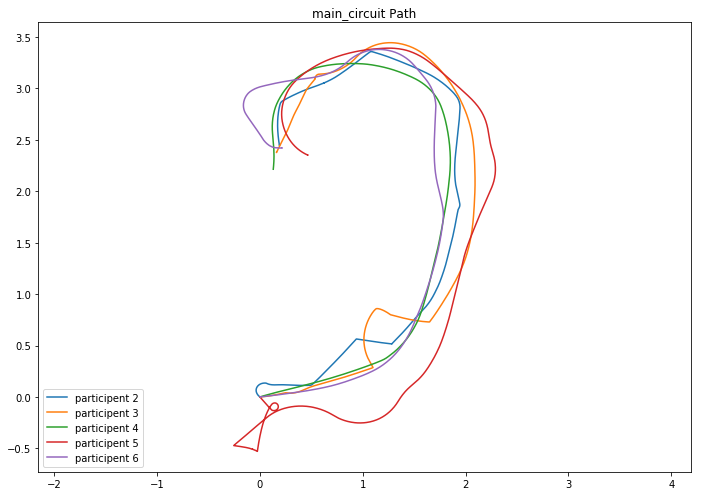

In [8]:
plot_odom("main_circuit",[2,3,4,5,6])

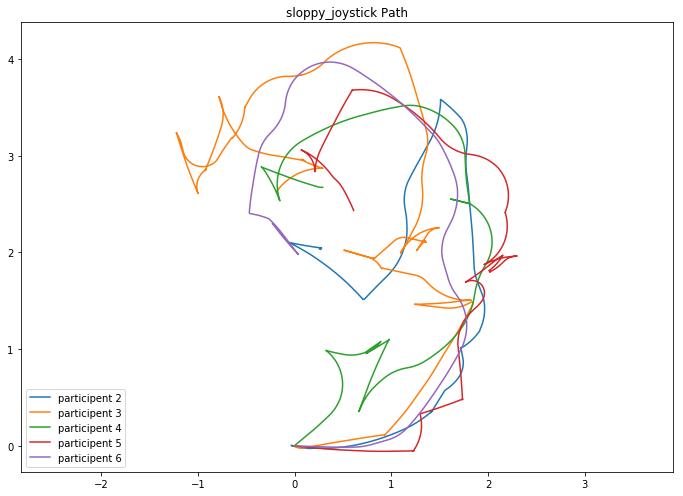

In [9]:
plot_odom("sloppy_joystick",[2,3,4,5,6])

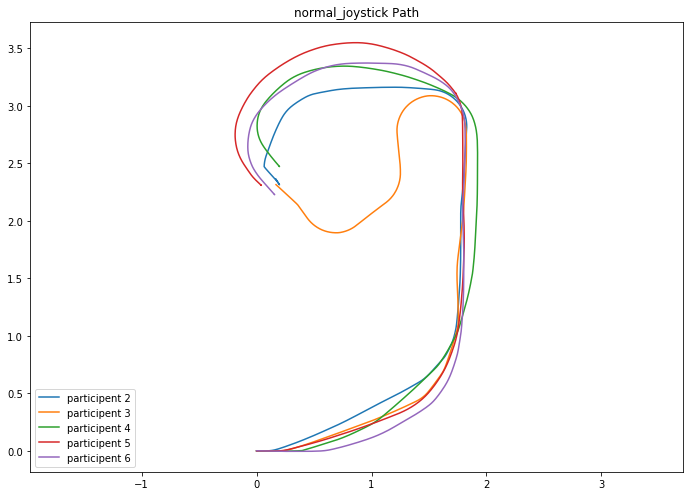

In [10]:
plot_odom("normal_joystick",[2,3,4,5,6])

In [11]:
# Time to target
# inf if not reached because collision

In [12]:
# create a HTML file for easy access (without jupyter)
os.system('jupyter nbconvert --to html visualization.ipynb') 
os.system('mv visualization.html ./html') # move to html folder

0